# Customer Segmentation - RFM Analysis + K-Means

## Objective
- Analyze customer behavior using RFM (Recency, Frequency, Monetary)
- Apply K-Means clustering for customer segmentation
- Run locally with pandas + sklearn, connecting to Databricks via SQL Connector

## Dataset
- Source: Olist Brazilian E-commerce (Gold layer)
- Tables: `dim_order`, `fct_order_payment`

---
## 1. Setup & Imports

In [26]:
import pandas as pd
import numpy as np
from pathlib import Path
import configparser

from databricks import sql

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

---
## 2. Configuration & Connection

In [27]:
databricks_cfg = configparser.ConfigParser()
databricks_cfg.read(Path.home() / ".databrickscfg")

DATABRICKS_HOST = databricks_cfg["DEFAULT"]["host"].rstrip("/")
DATABRICKS_TOKEN = databricks_cfg["DEFAULT"]["token"]
DATABRICKS_HTTP_PATH = "/sql/1.0/warehouses/956f28a1a104215e"

CATALOG = "olist_project"
GOLD_SCHEMA = "gold"

print(f"DATABRICKS_HOST: {DATABRICKS_HOST}")
print(f"CATALOG: {CATALOG}")
print(f"GOLD_SCHEMA: {GOLD_SCHEMA}")

DATABRICKS_HOST: https://dbc-2b5c4769-7757.cloud.databricks.com
CATALOG: olist_project
GOLD_SCHEMA: gold


In [28]:
def get_connection():
    return sql.connect(
        server_hostname=DATABRICKS_HOST.replace("https://", ""),
        http_path=DATABRICKS_HTTP_PATH,
        access_token=DATABRICKS_TOKEN
    )

with get_connection() as conn:
    cursor = conn.cursor()
    cursor.execute("SELECT 1")
    result = cursor.fetchone()
    print(f"Connection test: {result[0]} (expected: 1)")
    cursor.close()

print("Databricks connection successful!")

Connection test: 1 (expected: 1)
Databricks connection successful!


---
## 3. Load Data from Gold Tables

In [29]:
print("Loading dim_order...")
with get_connection() as conn:
    orders_pd = pd.read_sql(
        f"""
        SELECT DISTINCT 
            order_id, 
            customer_unique_id, 
            order_purchase_timestamp
        FROM {CATALOG}.{GOLD_SCHEMA}.dim_order 
        WHERE is_current = TRUE AND is_delivered = TRUE
        """,
        conn
    )
print(f"Orders: {len(orders_pd):,} rows")

Loading dim_order...


/var/folders/m3/sbsmdhx10cbfmbg14sn9j5hm0000gn/T/ipykernel_87297/3663702560.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  orders_pd = pd.read_sql(


Orders: 96,478 rows


In [30]:
print("Loading fct_order_payment...")
with get_connection() as conn:
    order_payments_pd = pd.read_sql(
        f"SELECT order_id, payment_value FROM {CATALOG}.{GOLD_SCHEMA}.fct_order_payment",
        conn
    )
print(f"Order Payments: {len(order_payments_pd):,} rows")

Loading fct_order_payment...


/var/folders/m3/sbsmdhx10cbfmbg14sn9j5hm0000gn/T/ipykernel_87297/1349685831.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  order_payments_pd = pd.read_sql(


Order Payments: 103,884 rows


In [31]:
print("=== Orders ===")
display(orders_pd.head(3))

print("\n=== Order Payments ===")
display(order_payments_pd.head(3))

=== Orders ===


,order_id,customer_unique_id,order_purchase_timestamp
0,e481f51cbdc54678b7cc49136f2d6af7,7c396fd4830fd04220f754e42b4e5bff,2017-10-02 10:56:33+00:00
1,53cdb2fc8bc7dce0b6741e2150273451,af07308b275d755c9edb36a90c618231,2018-07-24 20:41:37+00:00
2,47770eb9100c2d0c44946d9cf07ec65d,3a653a41f6f9fc3d2a113cf8398680e8,2018-08-08 08:38:49+00:00



=== Order Payments ===


,order_id,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,65.71


---
## 4. Feature Engineering - RFM Calculation

**RFM Analysis** is a proven customer segmentation technique that evaluates customers based on 3 behavioral metrics:

| Metric | Definition | Interpretation |
|--------|------------|----------------|
| **Recency (R)** | Days since last purchase | Lower = Better (recent buyer) |
| **Frequency (F)** | Number of unique orders | Higher = Better (repeat buyer) |
| **Monetary (M)** | Total spending amount | Higher = Better (high spender) |

Customers with **low Recency**, **high Frequency**, and **high Monetary** are the most valuable.

In [32]:
orders_pd['order_purchase_timestamp'] = pd.to_datetime(orders_pd['order_purchase_timestamp'])
max_date = orders_pd['order_purchase_timestamp'].max()
print(f"Reference date (max order date): {max_date}")

Reference date (max order date): 2018-08-29 15:00:37+00:00


In [33]:
orders_with_payments = orders_pd.merge(
    order_payments_pd[['order_id', 'payment_value']],
    on='order_id',
    how='inner'
)
print(f"Orders with payments: {len(orders_with_payments):,} rows")

Orders with payments: 100,754 rows


In [34]:
rfm_df = orders_with_payments.groupby('customer_unique_id').agg(
    recency_days=('order_purchase_timestamp', lambda x: (max_date - x.max()).days),
    frequency=('order_id', 'nunique'),
    monetary=('payment_value', 'sum')
).reset_index()

print(f"RFM DataFrame: {len(rfm_df):,} unique customers")
rfm_df.head(10)

RFM DataFrame: 93,355 unique customers


,customer_unique_id,recency_days,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19
2,0000f46a3911fa3c0805444483337064,536,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89
5,0004bd2a26a76fe21f786e4fbd80607f,145,1,166.98
6,00050ab1314c0e55a6ca13cf7181fecf,131,1,35.38
7,00053a61a98854899e70ed204dd4bafe,182,1,419.18
8,0005e1862207bf6ccc02e4228effd9a0,542,1,150.12
9,0005ef4cd20d2893f0d9fbd94d3c0d97,169,1,129.76


In [35]:
rfm_df.describe()

,recency_days,frequency,monetary
count,93355.000000,93355.000000,93355.000000
mean,236.939243,1.033421,165.200291
std,152.584930,0.209101,226.316705
min,0.000000,1.000000,9.590000
25%,113.000000,1.000000,63.060000
50%,218.000000,1.000000,107.780000
75%,345.000000,1.000000,182.575000
max,694.000000,15.000000,13664.080000


---
## 5. Exploratory Data Analysis

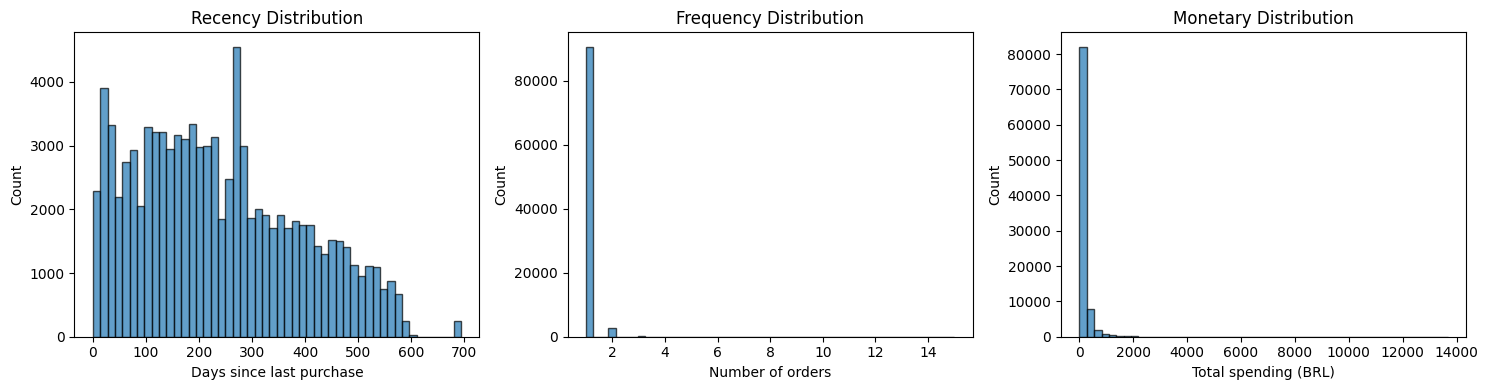

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(rfm_df['recency_days'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_title('Recency Distribution')
axes[0].set_xlabel('Days since last purchase')
axes[0].set_ylabel('Count')

axes[1].hist(rfm_df['frequency'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_title('Frequency Distribution')
axes[1].set_xlabel('Number of orders')
axes[1].set_ylabel('Count')

axes[2].hist(rfm_df['monetary'], bins=50, edgecolor='black', alpha=0.7)
axes[2].set_title('Monetary Distribution')
axes[2].set_xlabel('Total spending (BRL)')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

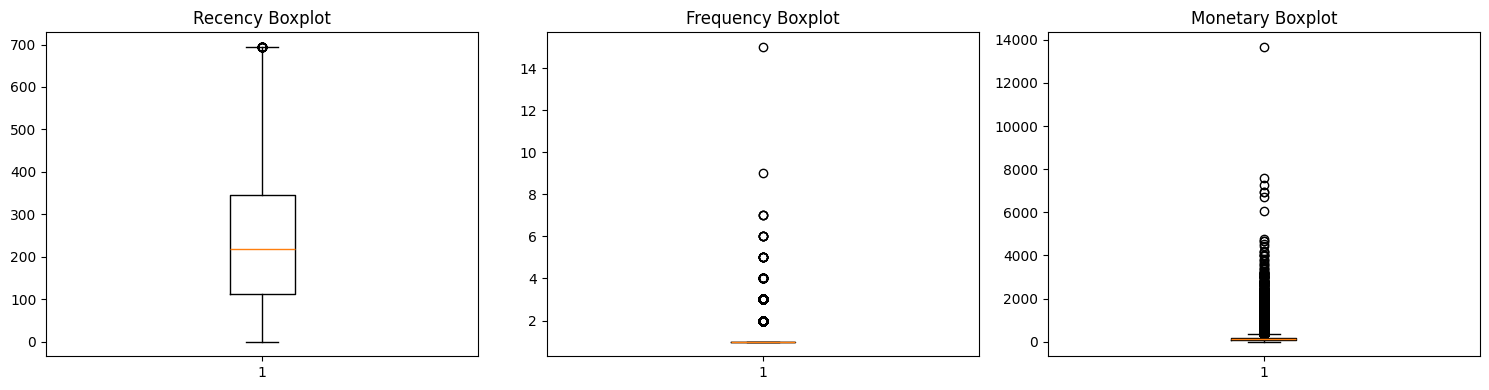

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].boxplot(rfm_df['recency_days'])
axes[0].set_title('Recency Boxplot')

axes[1].boxplot(rfm_df['frequency'])
axes[1].set_title('Frequency Boxplot')

axes[2].boxplot(rfm_df['monetary'])
axes[2].set_title('Monetary Boxplot')

plt.tight_layout()
plt.show()

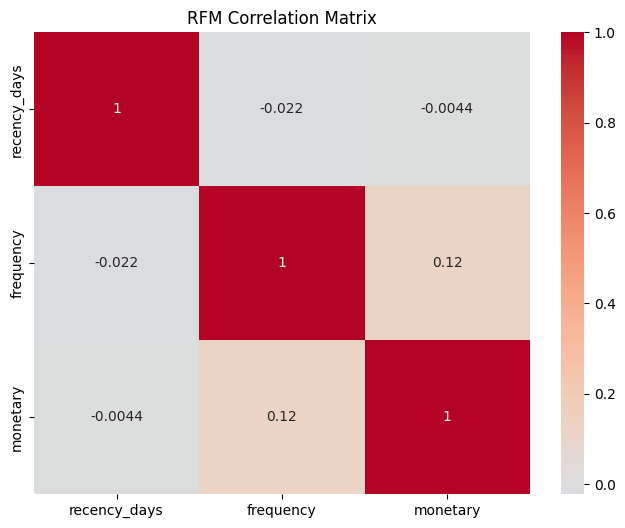

In [38]:
correlation_matrix = rfm_df[['recency_days', 'frequency', 'monetary']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('RFM Correlation Matrix')
plt.show()

---
## 6. Preprocessing

- Replace 0 with 1 for all RFM values (avoid log(0))
- Log transformation for Frequency and Monetary
- StandardScaler to normalize features

In [39]:
rfm_df['recency_days'] = rfm_df['recency_days'].replace(0, 1)
rfm_df['frequency'] = rfm_df['frequency'].replace(0, 1)
rfm_df['monetary'] = rfm_df['monetary'].replace(0, 1)

rfm_df['frequency_log'] = np.log10(rfm_df['frequency'])
rfm_df['monetary_log'] = np.log10(rfm_df['monetary'])

rfm_df.head()

,customer_unique_id,recency_days,frequency,monetary,frequency_log,monetary_log
0,0000366f3b9a7992bf8c76cfdf3221e2,111,1,141.90,0.0,2.151982
1,0000b849f77a49e4a4ce2b2a4ca5be3f,114,1,27.19,0.0,1.434409
2,0000f46a3911fa3c0805444483337064,536,1,86.22,0.0,1.935608
3,0000f6ccb0745a6a4b88665a16c9f078,320,1,43.62,0.0,1.639686
4,0004aac84e0df4da2b147fca70cf8255,287,1,196.89,0.0,2.294224


In [40]:
feature_cols = ['recency_days', 'frequency_log', 'monetary_log']
X = rfm_df[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Feature matrix shape: {X_scaled.shape}")
print(f"Mean after scaling: {X_scaled.mean(axis=0)}")
print(f"Std after scaling: {X_scaled.std(axis=0)}")

Feature matrix shape: (93355, 3)
Mean after scaling: [ 7.03274048e-17  1.07013345e-16 -2.11058326e-16]
Std after scaling: [1. 1. 1.]


---
## 7. Elbow Method - Optimal Cluster Selection

In [41]:
k_values = range(2, 11)
inertia_values = []
silhouette_values = []

for k in k_values:
    print(f"Training K-Means with k={k}...")
    kmeans = KMeans(n_clusters=k, random_state=5, n_init=10, max_iter=300)
    labels = kmeans.fit_predict(X_scaled)
    inertia_values.append(kmeans.inertia_)
    sil_score = silhouette_score(X_scaled, labels)
    silhouette_values.append(sil_score)
    print(f"  k={k}: Inertia={kmeans.inertia_:.2f}, Silhouette={sil_score:.4f}")

print("\nElbow analysis completed!")

Training K-Means with k=2...
  k=2: Inertia=188126.81, Silhouette=0.7115
Training K-Means with k=3...
  k=3: Inertia=124200.41, Silhouette=0.3581
Training K-Means with k=4...
  k=4: Inertia=83748.22, Silhouette=0.3694
Training K-Means with k=5...
  k=5: Inertia=68361.54, Silhouette=0.3531
Training K-Means with k=6...
  k=6: Inertia=57293.22, Silhouette=0.3443
Training K-Means with k=7...
  k=7: Inertia=48673.13, Silhouette=0.3581
Training K-Means with k=8...
  k=8: Inertia=43138.37, Silhouette=0.3484
Training K-Means with k=9...
  k=9: Inertia=39282.26, Silhouette=0.3479
Training K-Means with k=10...
  k=10: Inertia=36071.29, Silhouette=0.3508

Elbow analysis completed!


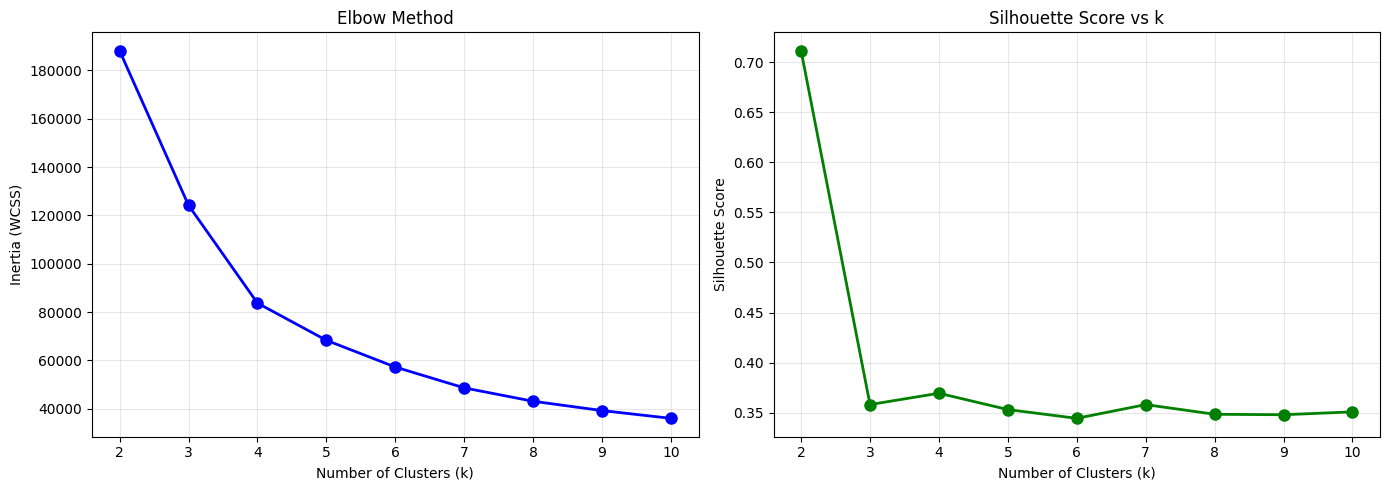


Best k based on Silhouette Score: 2
Max Silhouette Score: 0.7115


In [42]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(list(k_values), inertia_values, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia (WCSS)')
axes[0].set_title('Elbow Method')
axes[0].grid(True, alpha=0.3)

axes[1].plot(list(k_values), silhouette_values, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs k')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

best_k_silhouette = list(k_values)[np.argmax(silhouette_values)]
print(f"\nBest k based on Silhouette Score: {best_k_silhouette}")
print(f"Max Silhouette Score: {max(silhouette_values):.4f}")

In [43]:
OPTIMAL_K = 4
print(f"Selected optimal k: {OPTIMAL_K}")

Selected optimal k: 4


---
## 8. Train Final Model

In [44]:
kmeans_final = KMeans(n_clusters=OPTIMAL_K, random_state=5, n_init=10, max_iter=300)
rfm_df['cluster_id'] = kmeans_final.fit_predict(X_scaled)

inertia_final = kmeans_final.inertia_
silhouette_final = silhouette_score(X_scaled, rfm_df['cluster_id'])
n_customers = len(rfm_df)

print(f"Model trained successfully!")
print(f"Inertia: {inertia_final:.2f}")
print(f"Silhouette Score: {silhouette_final:.4f}")
print(f"Total customers: {n_customers:,}")

Model trained successfully!
Inertia: 83748.22
Silhouette Score: 0.3694
Total customers: 93,355


---
## 9. Cluster Analysis & Segment Naming

In [45]:
cluster_profile = rfm_df.groupby('cluster_id').agg(
    count=('customer_unique_id', 'count'),
    avg_recency=('recency_days', 'mean'),
    avg_frequency=('frequency', 'mean'),
    avg_monetary=('monetary', 'mean')
).reset_index()

cluster_profile = cluster_profile.sort_values('cluster_id')
cluster_profile['percentage'] = (cluster_profile['count'] / cluster_profile['count'].sum() * 100).round(1)
cluster_profile

,cluster_id,count,avg_recency,avg_frequency,avg_monetary,percentage
0,0,27000,424.201778,1.000000,118.652814,28.9
1,1,35743,145.993257,1.000000,69.368989,38.3
2,2,2801,219.295252,2.113888,308.588793,3.0
3,3,27811,173.800331,1.000000,319.112373,29.8


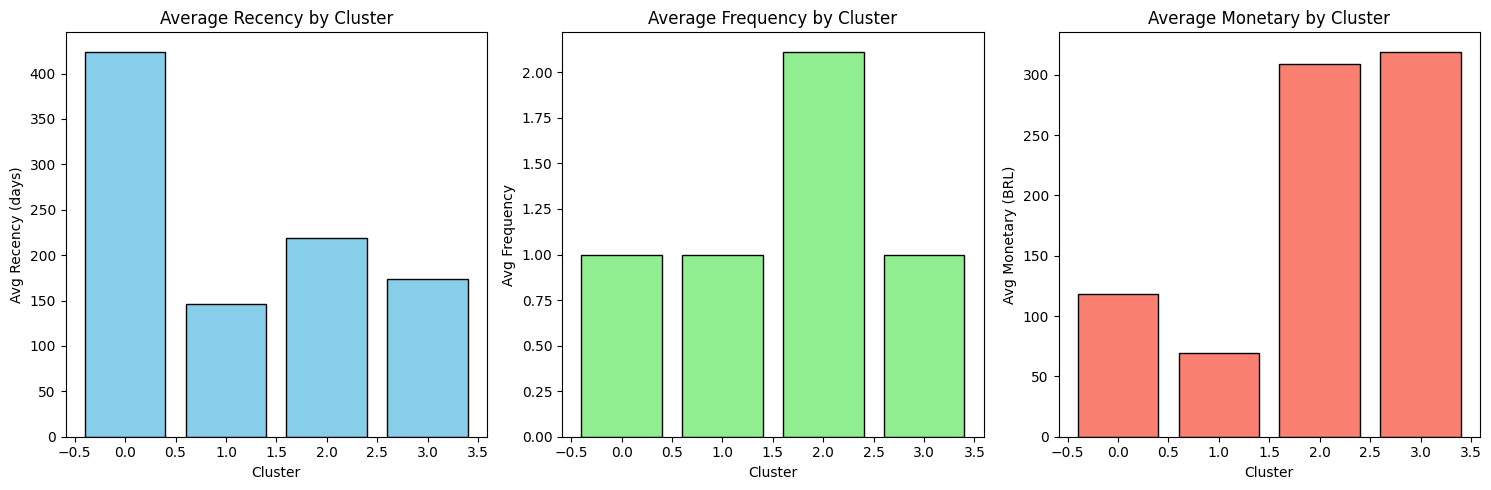

In [46]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].bar(cluster_profile['cluster_id'], cluster_profile['avg_recency'], color='skyblue', edgecolor='black')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Avg Recency (days)')
axes[0].set_title('Average Recency by Cluster')

axes[1].bar(cluster_profile['cluster_id'], cluster_profile['avg_frequency'], color='lightgreen', edgecolor='black')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Avg Frequency')
axes[1].set_title('Average Frequency by Cluster')

axes[2].bar(cluster_profile['cluster_id'], cluster_profile['avg_monetary'], color='salmon', edgecolor='black')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Avg Monetary (BRL)')
axes[2].set_title('Average Monetary by Cluster')

plt.tight_layout()
plt.show()

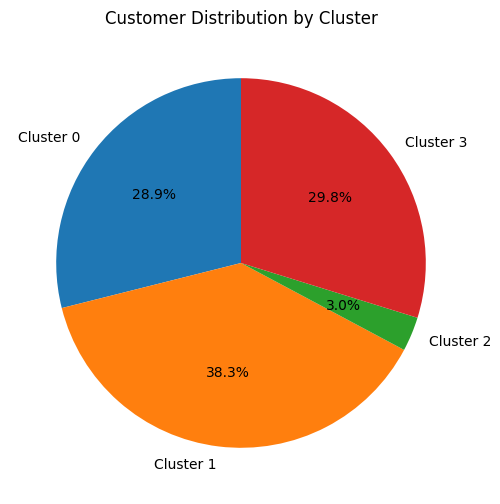

In [47]:
plt.figure(figsize=(8, 6))
plt.pie(
    cluster_profile['count'], 
    labels=[f"Cluster {i}" for i in cluster_profile['cluster_id']],
    autopct='%1.1f%%',
    startangle=90
)
plt.title('Customer Distribution by Cluster')
plt.show()

### Segment Naming & Business Insights

Based on RFM cluster profiles, we identify 4 distinct customer segments:

| Segment | % | Profile | Business Insight | Recommended Action |
|---------|---|---------|------------------|--------------------|
| **Churned Customers** | 29% | 400+ days inactive, low spend | Former customers who stopped buying | Send discounts to bring them back |
| **New Customers** | 38% | Recent purchase, single order, low spend | First-time buyers exploring the platform | Encourage 2nd purchase |
| **Loyal Customers** | 3% | Multiple orders (~2x), high total spend | Most valuable repeat customers | Give rewards to retain them |
| **High Spenders** | 30% | Recent, single order, high spend (~319 BRL) | Big spenders with growth potential | Suggest products to increase repeat orders |

In [48]:
SEGMENT_MAPPING = {
    0: "Churned Customers",
    1: "New Customers",
    2: "Loyal Customers",
    3: "High Spenders"
}

rfm_df['segment_name'] = rfm_df['cluster_id'].map(SEGMENT_MAPPING)

print("Segment Distribution:")
for cluster_id, segment_name in SEGMENT_MAPPING.items():
    count = len(rfm_df[rfm_df['cluster_id'] == cluster_id])
    pct = count / len(rfm_df) * 100
    print(f"  {segment_name}: {count:,} customers ({pct:.1f}%)")

Segment Distribution:
  Churned Customers: 27,000 customers (28.9%)
  New Customers: 35,743 customers (38.3%)
  Loyal Customers: 2,801 customers (3.0%)
  High Spenders: 27,811 customers (29.8%)


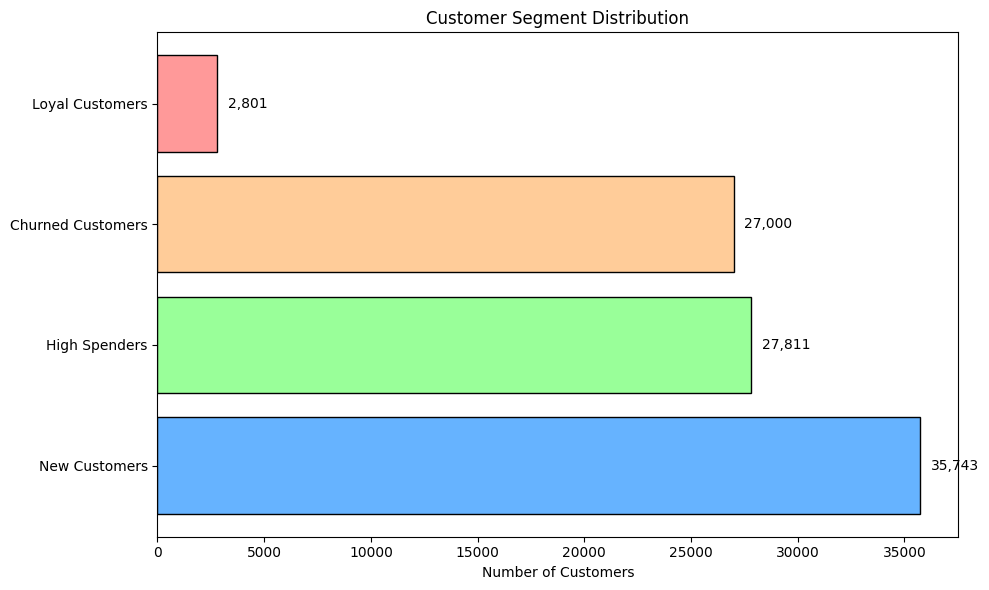

In [49]:
segment_counts = rfm_df['segment_name'].value_counts()

plt.figure(figsize=(10, 6))
colors = ['#66b3ff', '#99ff99', '#ffcc99', '#ff9999']
plt.barh(segment_counts.index, segment_counts.values, color=colors, edgecolor='black')
plt.xlabel('Number of Customers')
plt.title('Customer Segment Distribution')

for i, v in enumerate(segment_counts.values):
    plt.text(v + 500, i, f'{v:,}', va='center')

plt.tight_layout()
plt.show()

---
## 10. Summary

### Customer Segments

| Segment | % | Strategy |
|---------|---|----------|
| **New Customers** | 38% | Encourage 2nd purchase |
| **High Spenders** | 30% | Suggest products to increase repeat orders |
| **Churned Customers** | 29% | Send discounts to bring them back |
| **Loyal Customers** | 3% | Give rewards to retain them |

### Key Takeaways

1. **67% of customers are one-time buyers** (New + Churned) → Focus on retention strategies
2. **Only 3% are repeat buyers** (Loyal Customers) → High opportunity to grow this segment
3. **29% have churned** → Significant revenue recovery opportunity with win-back campaigns
4. **30% are high spenders** → Convert them to loyal customers for long-term value

In [50]:
print("="*60)
print("CUSTOMER SEGMENTATION - SUMMARY")
print("="*60)
print(f"\nModel: K-Means (k={OPTIMAL_K})")
print(f"Silhouette Score: {silhouette_final:.4f}")
print(f"Total customers: {n_customers:,}")
print("\nSegment Distribution:")
print("-"*60)

for _, row in cluster_profile.iterrows():
    segment = SEGMENT_MAPPING[row['cluster_id']]
    print(f"{segment}:")
    print(f"  Count: {row['count']:,} ({row['percentage']}%)")
    print(f"  Avg R: {row['avg_recency']:.0f} days | Avg F: {row['avg_frequency']:.2f} | Avg M: {row['avg_monetary']:.2f} BRL")

print("="*60)

CUSTOMER SEGMENTATION - SUMMARY

Model: K-Means (k=4)
Silhouette Score: 0.3694
Total customers: 93,355

Segment Distribution:
------------------------------------------------------------
Churned Customers:
  Count: 27,000.0 (28.9%)
  Avg R: 424 days | Avg F: 1.00 | Avg M: 118.65 BRL
New Customers:
  Count: 35,743.0 (38.3%)
  Avg R: 146 days | Avg F: 1.00 | Avg M: 69.37 BRL
Loyal Customers:
  Count: 2,801.0 (3.0%)
  Avg R: 219 days | Avg F: 2.11 | Avg M: 308.59 BRL
High Spenders:
  Count: 27,811.0 (29.8%)
  Avg R: 174 days | Avg F: 1.00 | Avg M: 319.11 BRL
